##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST の分類

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/quantum/tutorials/mnist.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/quantum/tutorials/mnist.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/quantum/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、簡略化された MNIST バージョンを分類する、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a> で使用されたアプローチに似た量子ニューラルネットワーク（QNN）を構築し、古典的なデータ問題における量子ニューラルネットワークのパフォーマンスを従来のニューラルネットワークと比較します。

## セットアップ

In [1]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 20 kB/s 
     |████████████████████████████████| 1.3 MB 5.3 MB/s 
     |████████████████████████████████| 463 kB 52.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab202207

TensorFlow Quantum をインストールします。

In [2]:
!pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 5.3 MB/s 
     |████████████████████████████████| 100 kB 9.5 MB/s 
     |████████████████████████████████| 576 kB 42.7 MB/s 
     |████████████████████████████████| 1.6 MB 51.7 MB/s 
     |████████████████████████████████| 90 kB 3.2 MB/s 
     |████████████████████████████████| 6.1 MB 35.8 MB/s 
     |████████████████████████████████| 90 kB 7.8 MB/s 
     |████████████████████████████████| 47 kB 3.4 MB/s 
     |████████████████████████████████| 641 kB 53.1 MB/s 
     |████████████████████████████████| 541 kB 38.9 MB/s 
     |████████████████████████████████| 541 kB 53.8 MB/s 
     |████████████████████████████████| 437 kB 50.9 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 k

In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

次に、TensorFlow とモジュールの依存関係をインポートします。

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. データを読み込む

このチュートリアルでは、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> に従って、数字の 3 と 6 を区別する二項分類器を構築します。このセクションでは、次を行うデータ処理を説明します。

- Keras から生データを読み込みます。
- データセットを 3 と 6 に絞り込みます。
- 画像が量子コンピュータに適合するように、画像を縮小します。
- 矛盾するサンプルを取り除きます。
- バイナリ画像を Cirq 回路に変換します。
- Cirq 回路を TensorFlow Quantum 回路に変換します。 

### 1.1 生データを読み込む

Keras で配布された MNIST データセットを読み込みます。 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11501568/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


3 と 6 の数字のみを保持してほかのクラスを取り除くように、データセットを絞り込みます。同時に、`3` を `True`、6 を `False` というように、ラベル `y` をブール型に変換します。 

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [5]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


最初のサンプルを表示します。

True


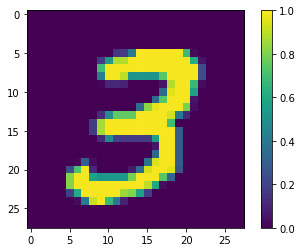

In [6]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 画像を縮小する

現在の量子コンピュータでは、画像サイズ 28x28 は大きすぎるため、4x4 に縮小します。

In [7]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

サイズ変更を行ったら、もう一度最初のサンプルを表示します。 

True


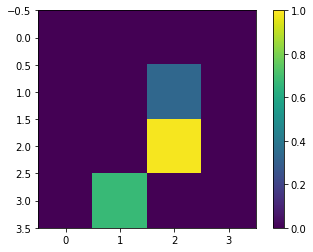

In [8]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 矛盾するサンプルを取り除く

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> の *3.3 Learning to Distinguish Digits* セクションに説明されているように、データセットから両方のクラスに属するラベルが付けられた画像を取り除きます。

これは標準的な機械学習の手順ではありませんが、論文の手順に従う目的で追加している手順です。

In [9]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

取り除いた結果の数量は、レポートされている値に密に一致していませんが、これは正確な手順が指定されていないためです。

また、この時点で、矛盾するサンプルをフィルタリングすることで、矛盾するトレーニングサンプルがモデルに絶対に送られないということではありません。次のデータの二項化のステップでは、さらに競合が発生します。 

In [10]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.4 データを量子回路としてエンコードする

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、量子コンピュータを使って画像を処理するには、ピクセルの値に応じた状態で、各ピクセルをキュービットで表現するように提案しています。最初のステップでは、バイナリエンコーディングへの変換を行います。

In [11]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

この時点で矛盾した画像を取り除く場合、193 個しか画像が残らず、これでは有効なトレーニングを行える数量とは言えません。

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

しきい値を超える値を持つピクセルインデックスのキュービットは、$X$ ゲートを介して循環します。

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

これは最初のサンプルに作成された回路です（回路図には、ゼロゲートのキュービットは表示されていません）。

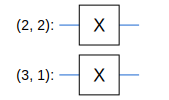

In [13]:
SVGCircuit(x_train_circ[0])

この回路を、画像の値がしきい値を超えるインデックスを比較します。

In [14]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

これらの `Cirq` 回路を `tfq` のテンソルに変換します。

In [15]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. 量子ニューラルネットワーク

画像を分類する量子回路構造に関するガイダンスはほとんどありません。分類は読み出されるキュービットの期待に基づいて行われるため、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、2 つのキュービットゲートを使用して、読み出しキュービットが必ず作用されるようにすることを提案しています。これはある意味、ピクセル全体に小さな<a href="https://arxiv.org/abs/1511.06464" class="external">ユニタリ RNN</a>を実行することに似ています。

### 2.1 モデル回路を構築する

次の例では、このレイヤー化アプローチを説明しています。各レイヤーは同一ゲートの *n* 個のインスタンスを使用しており、各データキュービットは読み出しキュービットに影響を与えています。

ゲートのレイヤーを回路に追加する簡単なクラスから始めましょう。

In [16]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

サンプル回路レイヤーを構築して、どのようになるかを確認します。

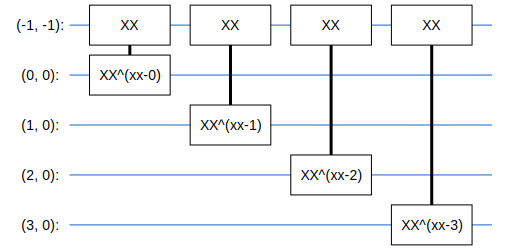

In [17]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

では、2 レイヤーモデルを構築しましょう。 データ回路サイズに一致するようにし、準備と読み出し演算を含めます。

In [18]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [20]:
model_circuit, model_readout = create_quantum_model()

### 2.2 tfq-keras モデルでモデル回路をラップする

量子コンポーネントで Keras モデルを構築します。このモデルには、古典的なデータをエンコードする「量子データ」が `x_train_circ` からフィードされます。*パラメータ化された量子回路*レイヤーの `tfq.layers.PQC` を使用して、量子データでモデル回路をトレーニングするモデルです。

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、画像を分類するには、パラメータ化された回路で読み出しキュービットの期待値を使用することを提案しています。期待値は、1 から -1 の値です。

In [21]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

次に、`compile` メソッドを使用して、モデルにトレーニング手順を指定します。

期待される読み出しは `[-1,1]` の範囲であるため、ヒンジ損失を最適化すると、ある程度自然な適合となります。

注意: もう 1 つの有効なアプローチとして、出力範囲を `[0,1]` にシフトし、モデルがクラス `3` に割りてる確率として扱う方法があります。これは、標準的な`tf.losses.BinaryCrossentropy` 損失で使用することができます。

ここでヒンジ損失を使用するには、小さな調整を 2 つ行う必要があります。まず、ラベル `y_train_nocon` をブール型からヒンジ損失が期待する `[-1,1]` に変換することです。

In [22]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

次に、`[-1, 1]` を `y_true` ラベル引数として正しく処理するカスタムの `hinge_accuracy` メトリックを使用します。`tf.losses.BinaryAccuracy(threshold=0.0)` は `y_true` がブール型であることを期待するため、ヒンジ損失とは使用できません。

In [23]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [24]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

### 量子モデルをトレーニングする

では、モデルをトレーニングしましょう。これには約 45 分かかりますが、その時間を待てない方は、小規模なデータのサブセット（以下の`NUM_EXAMPLES=500` セット）を使用するとよいでしょう。トレーニング時のモデルの進捗にあまり影響はありません（パラメータは 32 しかなく、これらを制約する上であまりデータは必要ありません）。サンプル数を減らすことでトレーニングを早めに（5 分程度）終わらせることができますが、検証ログに進捗状況を示すには十分な長さです。

In [25]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [26]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

このモデルを収束までトレーニングすると、テストセットにおいて 85% を超える精度が達成されます。

In [27]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 716s 2s/step - loss: 0.7327 - hinge_accuracy: 0.7097 - val_loss: 0.3713 - val_hinge_accuracy: 0.8291
Epoch 2/3
324/324 [==============================] - 717s 2s/step - loss: 0.3657 - hinge_accuracy: 0.8245 - val_loss: 0.3370 - val_hinge_accuracy: 0.8564
Epoch 3/3
62/62 [==============================] - 24s 379ms/step - loss: 0.3301 - hinge_accuracy: 0.9068


注意: トレーニング精度はエポックの平均値を示します。検証精度はエポックの終了ごとに評価されます。

## 3. 従来のニューラルネットワーク

量子ニューラルネットワークは、この単純化された MNIST 問題で機能するものの、このタスクでは、従来のニューラルネットワークの性能が QNN をはるかに上回ります。1 つのエポックが終了した時点で、従来のニューラルネットワークは縮小したセットで 98% を超える精度を達成することができます。

次の例では、画像をサブサンプリングする代わりに 28x28 の画像を使用した 3 と 6 の分類問題に従来のニューラルネットワークを使用しています。これはほぼ 100% 精度のテストセットに難なく収束します。

In [ ]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

上記のモデルには約 120 万個のパラメータがあります。より公正な比較を行うために、サブサンプリングした画像で 37 個のパラメータモデルを使用してみましょう。

In [ ]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

## 4. 比較

解像度の高い入力とより強力なモデルの場合、CNN はこの問題を簡単に解決できますが、似たようなパワー（最大 32 個のパラメータ）を持つ古典的モデルはわずかな時間で似たような精度までトレーニングすることができます。いずれにせよ、従来のニューラルネットワークは量子ニューラルネットワークの性能を簡単に上回ります。古典的なデータでは、従来のニューラルネットワークを上回るのは困難といえます。

In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])